# Capstone project VII - Principal component analysis and Clustering

## US Arrest data

This data set contains statistics, in arrests per 100,000 residents,for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas.”

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from pca import pca

from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

%matplotlib inline

In [58]:
# Load data
df = pd.read_csv('UsArrests.csv')
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


## Pre-processing

In [59]:
# view summary data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


The Assault and UrbanPop fields are currently held as integer

In [60]:
#convert all numerical data to float
df['Assault'] = df['Assault'].astype('float64')
df['UrbanPop'] = df['UrbanPop'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     float64
 3   UrbanPop  50 non-null     float64
 4   Rape      50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [61]:
# rename City column State as it contains US State data
df.rename(columns={'City':'State'}, inplace = True)
df.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236.0,58.0,21.2
1,Alaska,10.0,263.0,48.0,44.5
2,Arizona,8.1,294.0,80.0,31.0
3,Arkansas,8.8,190.0,50.0,19.5
4,California,9.0,276.0,91.0,40.6


In [62]:
# check for any missing values
df.isnull().sum()

State       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

There is no missing data.

## Data exploration 

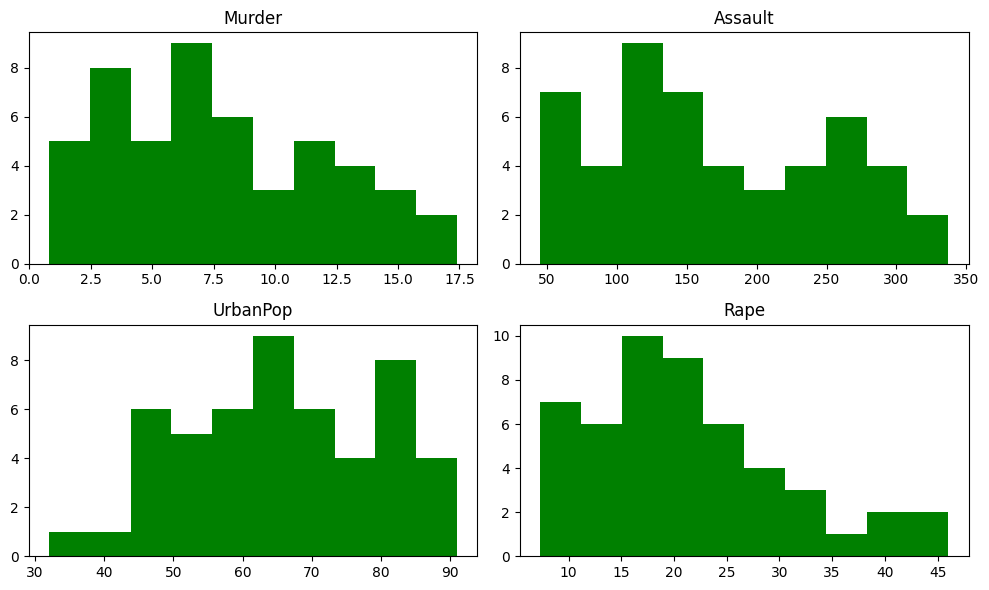

In [63]:
# Plot histograms
histograms = df.hist(color='green', grid=False, figsize=(10, 6)) 
plt.tight_layout()
plt.show()

In [64]:
# view summary data
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


The values for Assault are significantly higher than Murder and Rape so we will scale the data to avoid this having too much influence on the combined results.

In [65]:
# Scale the data

scaled = StandardScaler().fit_transform(df.iloc[:,1:5])

df_scaled = pd.DataFrame(scaled, columns=df.columns[1:5])
df_scaled.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


## Principal Component Analysis 

Principal Components Analysis (PCA) is a method for reducing the number of dimensions in a dataset by finding the underlying variables (i.e. principal components) that best differentiate the observations by determining the directions along which your data points are most spread out. Since the determination of the principal components is based on finding the direction that maximises the variance, variables with variance that are much higher than the other variables tend to dominate the analysis purely due to their scale. PCA is useful when we have a lot of variables, and need to reduce these.

Text(0.5, 1.0, 'Correlations of the original features')

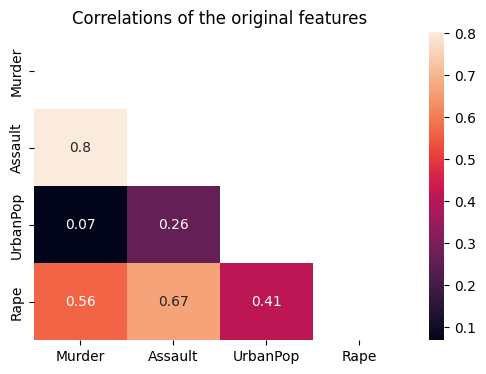

In [66]:
# Explore the correlations of the independant fearures on a heatmap

corrs = df.corr(numeric_only=True)

plt.figure(figsize=(6, 4))

# to mask mirrored side of heatmap
dropSelf = np.zeros_like(corrs)
dropSelf[np.triu_indices_from(dropSelf)] = True

# Generate heatmap
sns.heatmap(corrs, annot=True, mask=dropSelf)
plt.title('Correlations of the original features')



In the plot, the lighter the colour the higher the correlation between the variables. 

It can be seen that the highest correlations are between the variables Assault and Murder and Assault and Rape, which may indicate that Murder and Rape are more likely to occur in places where Assaults are high.

The high correlation can be extracted from the dataset as redundant data as it is almost duplicated in each variable 



In [67]:
pc = PCA().fit(df_scaled)

print(f"Proportion of Variance Explained: {pc.explained_variance_ratio_}")

Proportion of Variance Explained: [0.62006039 0.24744129 0.0891408  0.04335752]


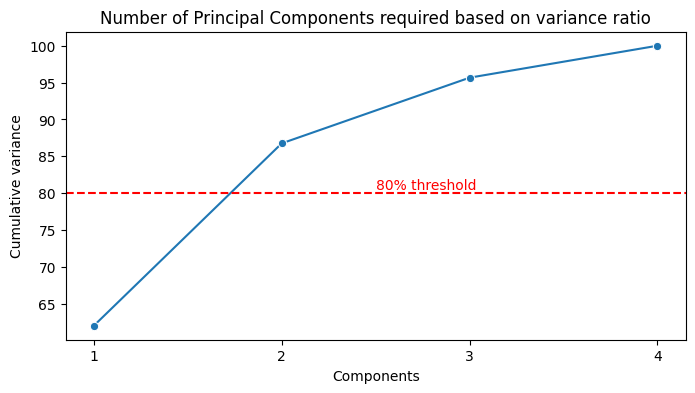

In [68]:
# visualise the number of principal components required, when explained variance goes above 80%
X = np.arange(1,5, step=1)

plt.figure(figsize=(8,4))
sns.lineplot(x=X, y=np.cumsum(pc.explained_variance_ratio_)*100, marker='o')

plt.title('Number of Principal Components required based on variance ratio')
plt.xlabel('Components')
plt.ylabel('Cumulative variance')
plt.xticks(np.arange(1,5, step=1))
plt.axhline(y=80, color='r', linestyle='--')
plt.text(2.5, 80.5, '80% threshold', color='r')
plt.show()

The cumulative variance goes above 80% with 2 principal components, so we can actually reduce the variables in the dataset from 4 to 2 components and still maintain over 85% of the explained variance.

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [50] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [50] unique colors! Available unique colors: [9].


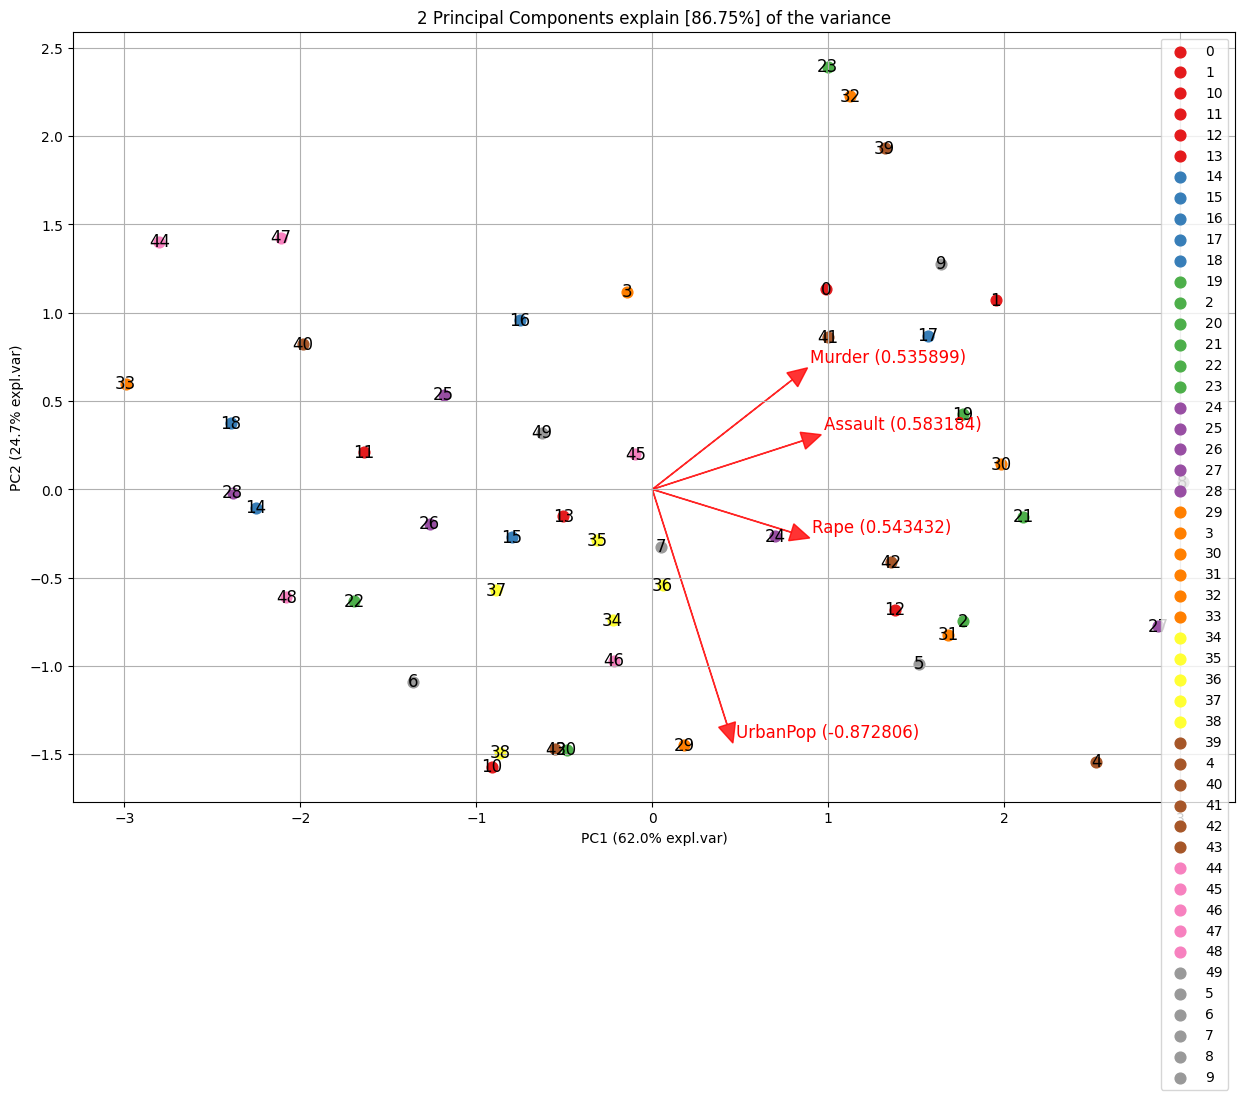

In [69]:
#  run pca with 2 components and visualise each States correlation to the principal component within the dataframe
model = pca(n_components=2)
results = model.fit_transform(df_scaled)
fig,ax = model.biplot(n_feat=4,)

86.75% of the vaiance is explained by the 2 principal components. the vector lines represent the influence each of the original features has on the principal components.

## Clustering analysis 

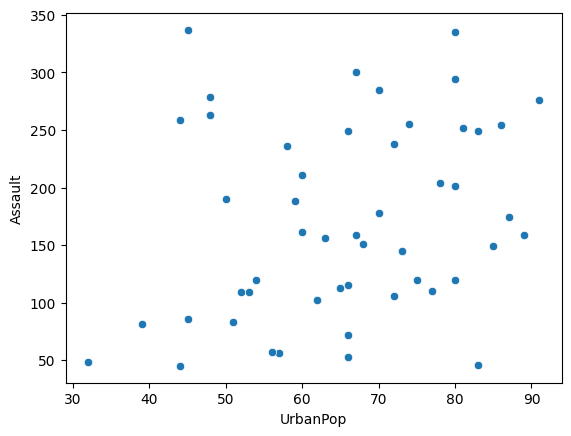

In [70]:
# explore the continuous independent features

sns.scatterplot(data=df, x='UrbanPop', y='Assault',)
plt.xlabel('UrbanPop')
plt.ylabel('Assault')
plt.show()

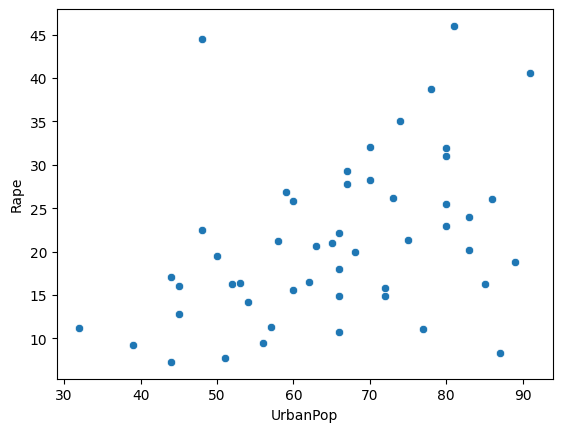

In [71]:
sns.scatterplot(data=df, x='UrbanPop', y='Rape',)
plt.xlabel('UrbanPop')
plt.ylabel('Rape')
plt.show()

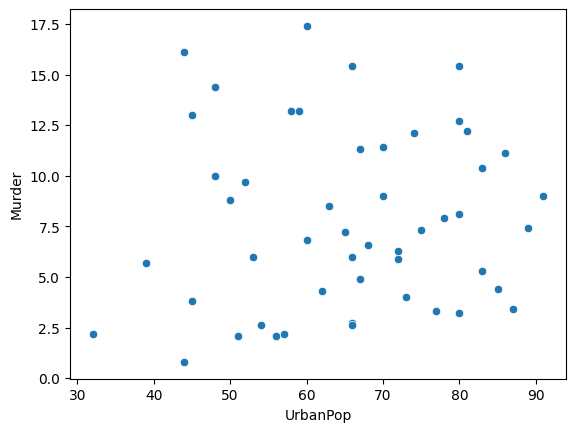

In [73]:
sns.scatterplot(data=df, x='UrbanPop', y='Murder',)
plt.xlabel('UrbanPop')
plt.ylabel('Murder')
plt.show()

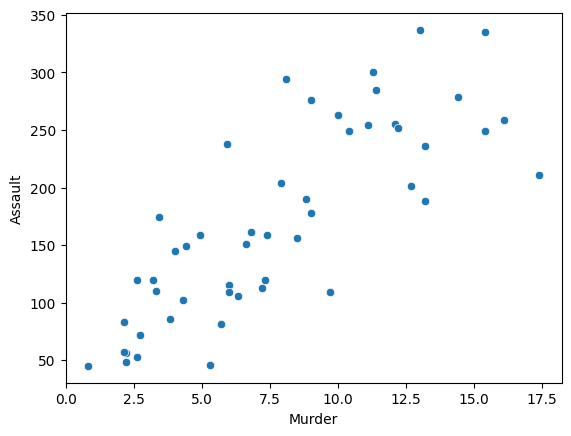

In [74]:
sns.scatterplot(data=df, x='Murder', y='Assault',)
plt.xlabel('Murder')
plt.ylabel('Assault')
plt.show()

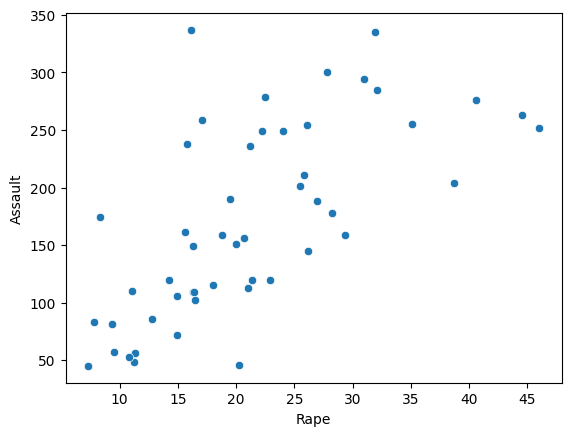

In [75]:
sns.scatterplot(data=df, x='Rape', y='Assault',)
plt.xlabel('Rape')
plt.ylabel('Assault')
plt.show()

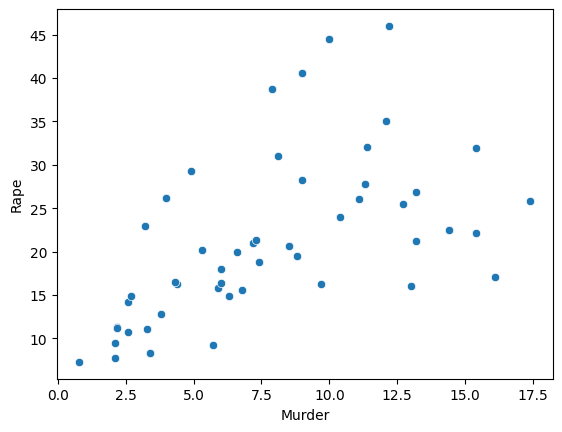

In [76]:
sns.scatterplot(data=df, x='Murder', y='Rape',)
plt.xlabel('Murder')
plt.ylabel('Rape')
plt.show()

From the scatter plots there is no obvoius clustering to be analyesed but the data best suited for cluster anaysis appears to be Assuault vs Urban population, the data does not follow a normal linear relationship and there will be overlap in the clusters.

### K-means

In [120]:
# prepare data for training
X = df_scaled[['UrbanPop','Assault']].values.reshape(-1,2)  

print('Data size:')
print(X.shape)

Data size:
(50, 2)


/home/elliottchris895/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/elliottchris895/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/elliottchris895/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/elliottchris895/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


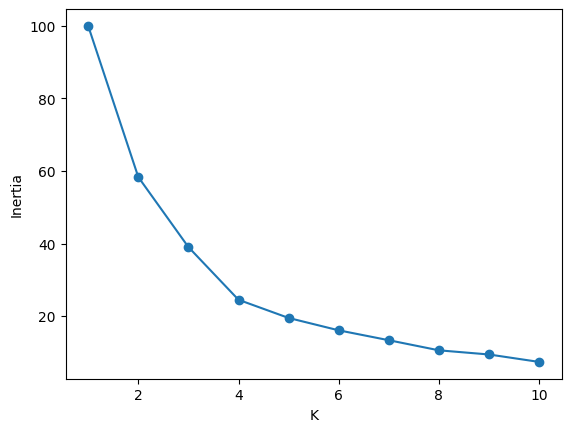

In [121]:
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r)
    kmeans.fit(x)    
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1,max_k+1)]
    plt.plot(range(1,11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

elbow_Kmeans(X)


Fron the plot above we can see the 'elbow' occurs between 2 and 5 for K

/home/elliottchris895/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


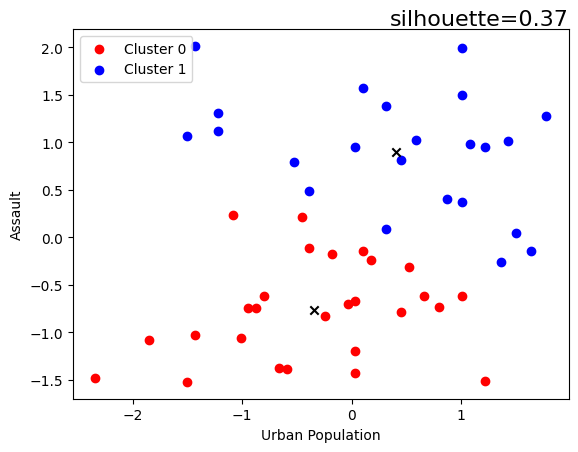

/home/elliottchris895/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


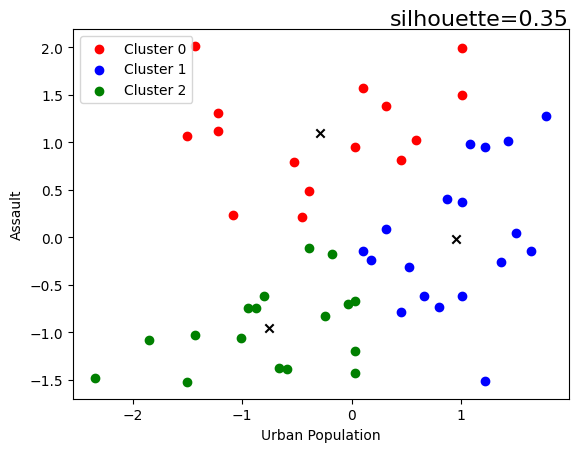

/home/elliottchris895/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


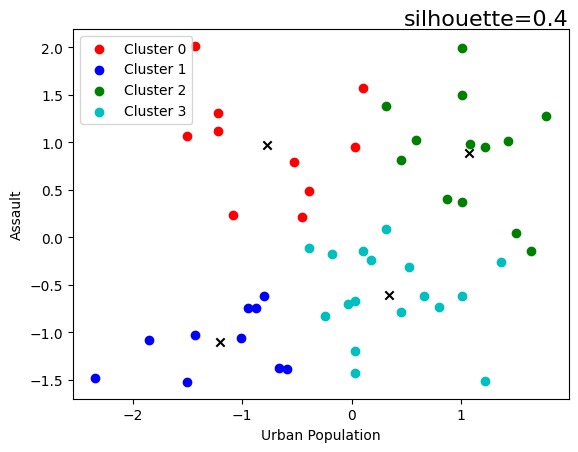

/home/elliottchris895/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


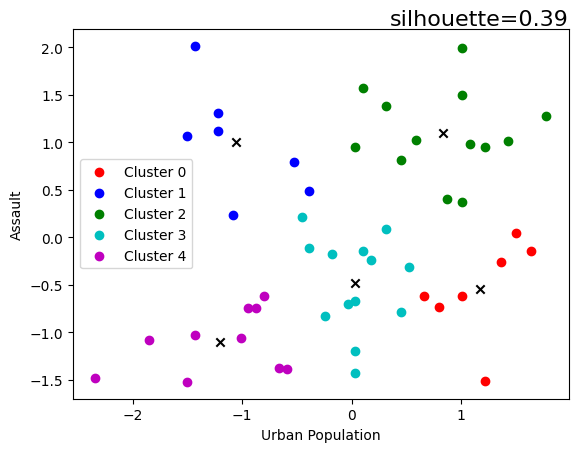

In [122]:
def scatter_Kmeans(x, k, r=123):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    
    score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel('Urban Population')
    plt.ylabel('Assault')
    plt.legend()
    plt.show()

for k in range(2,6):
    scatter_Kmeans(X, k, r=0)

The best silhouette score was returned for k=4, 

### Hierarchical clustering

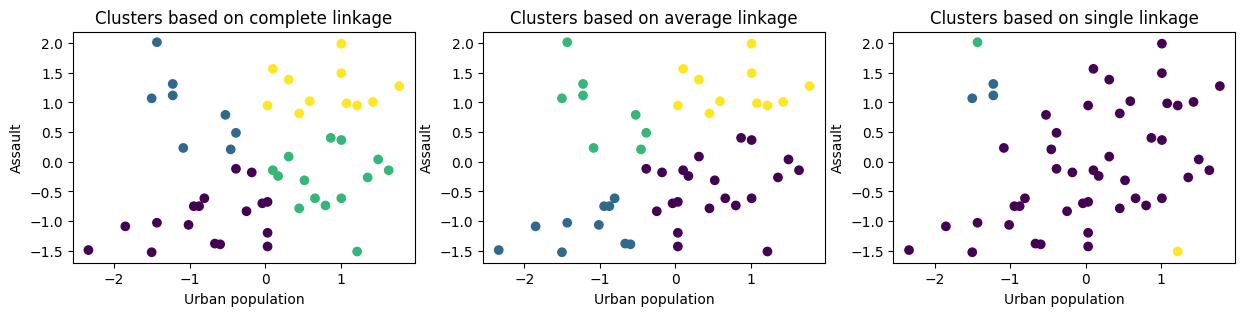

In [124]:
# whic linkage returns the most suitable clustering
plt.figure(figsize=[15,3])

linkage_types = ['complete', 'average', 'single']

for i, l in enumerate(linkage_types):
  plt.subplot(1, 3, i+1)
  
  cluster = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage=l)
  cluster.fit_predict(X)

  ax = plt.scatter(X[:,0], X[:,1], c=cluster.labels_)
  
  plt.title('Clusters based on {} linkage'.format(l))
  plt.xlabel('Urban population')
  plt.ylabel('Assault')
 
L = 'complete'

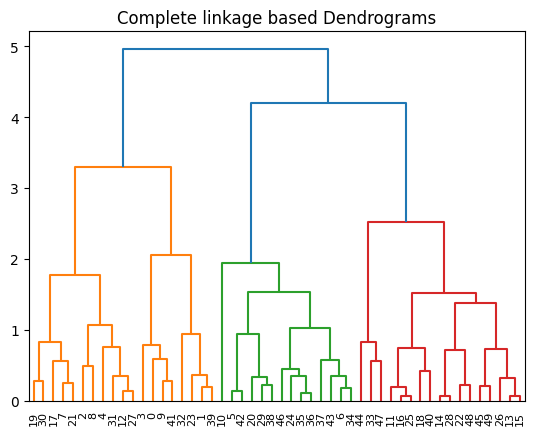

In [125]:
# plot dendrograms to visualise the number of clusters to be analysed
plt.title("Complete linkage based Dendrograms")  
dend = dendrogram(linkage(X, method='complete'))  

Reviewing the dendrogram above confirms there are 3 identifiable clusters which could be used to classify the groups.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


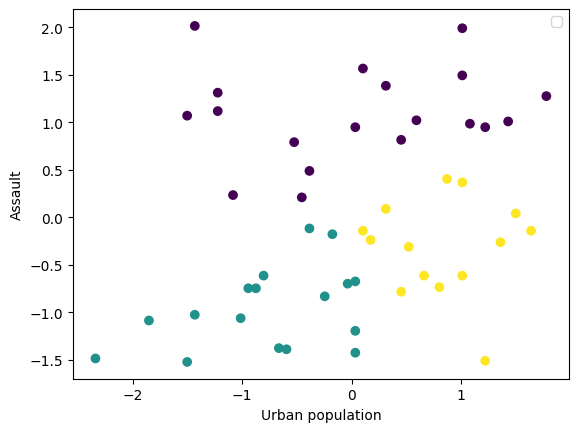

In [127]:
cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage=L)
cluster.fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=cluster.labels_)
plt.xlabel('Urban population')
plt.ylabel('Assault')
plt.legend()


The States in cluster 0 could be seen as relatively safe states with low levels of assault. The States in Cluster 2 have higher levels of assault and could be used by authorities to target policing support. Cluster 1 can be monitored for any changes with targeted policing or education.

In [ ]:
https://github.com/chriselliott27